In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt


In [2]:
def msd_straight_forward(r):
    shifts = np.arange(len(r))
    msds = np.zeros(shifts.size)    

    for i, shift in enumerate(shifts):
        diffs = r[:-shift if shift else None] - r[shift:]
        sqdist = np.square(diffs).sum(axis=1)
        msds[i] = sqdist.mean()

    return msds

In [3]:
r = np.cumsum(np.random.choice([-1., 0., 1.], size=(10000, 3)), axis=0)


In [4]:
def autocorrFFT(x):
      N=len(x)
      F = np.fft.fft(x, n=2*N)  #2*N because of zero-padding
      PSD = F * F.conjugate()
      res = np.fft.ifft(PSD)
      res= (res[:N]).real   #now we have the autocorrelation in convention B
      n=N*np.ones(N)-np.arange(0,N) #divide res(m) by (N-m)
      return res/n #this is the autocorrelation in convention A

In [5]:
def msd_fft(r):
  N=len(r)
  D=np.square(r).sum(axis=1) 
  D=np.append(D,0) 
  S2=sum([autocorrFFT(r[:, i]) for i in range(r.shape[1])])
  Q=2*D.sum()
  S1=np.zeros(N)
  for m in range(N):
      Q=Q-D[m-1]-D[N-m]
      S1[m]=Q/(N-m)
  return S1-2*S2

In [6]:
msd=msd_fft(r)

In [7]:
for i in range(0,1000):
    r = np.cumsum(np.random.choice([-1., 1.], size=(10000, 3)), axis=0)
    msd+=msd_fft(r)

In [8]:
r

array([[-1., -1.,  1.],
       [-2.,  0.,  0.],
       [-3., -1., -1.],
       ...,
       [54., 90., 30.],
       [55., 89., 29.],
       [56., 88., 28.]])

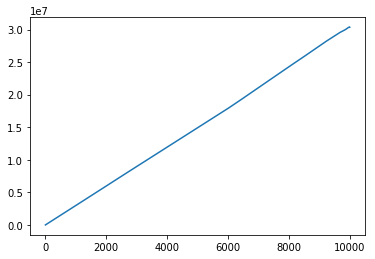

In [9]:
plt.plot(msd)

In [10]:
x=np.arange(2000)
y=msd[0:2000]

In [11]:
np.polyfit(x, y, deg=1, rcond=None, full=False, w=None, cov=False)

array([2984.86976258, 3082.2069168 ])

In [12]:
y

array([1.75077730e-10, 3.00200390e+03, 6.00484597e+03, ...,
       5.97032071e+06, 5.97334997e+06, 5.97637887e+06])